In [214]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [215]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [216]:
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

## Reflect and query dates

In [217]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)

# Print all of the classes mapped to the Base
Base.classes.keys()

['measurements', 'stations']

In [218]:
# Use SQLAlchemy automap_base() to reflect your tables into classes and save a reference to those classes called Station and Measurement.
Measurement = Base.classes.measurements
Station = Base.classes.stations
session = Session(engine)

## Precipitation Analysis

In [219]:
# Find last data date
data_last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
data_last_date

'2017-08-23'

In [220]:
# Find the previous year of last data date
data_start_date_dt = dt.datetime.strptime(data_last_date , "%Y-%m-%d")\
    - dt.timedelta(365)
data_start_date = data_start_date_dt.strftime("%Y-%m-%d")
data_start_date

'2016-08-23'

In [221]:
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= data_start_date, Measurement.date <= data_last_date).all()

# Dataframe for Percipitation
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])
df.head()

,Date,Precipitation
0,2016-09-05,0.0
1,2016-09-06,0.0
2,2016-08-31,0.0
3,2016-09-05,0.0
4,2016-09-12,0.0


In [222]:
prcp_df = df.sort_values('Date')
prcp_df.set_index('Date', inplace=True)
prcp_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.00
2016-08-23,0.02


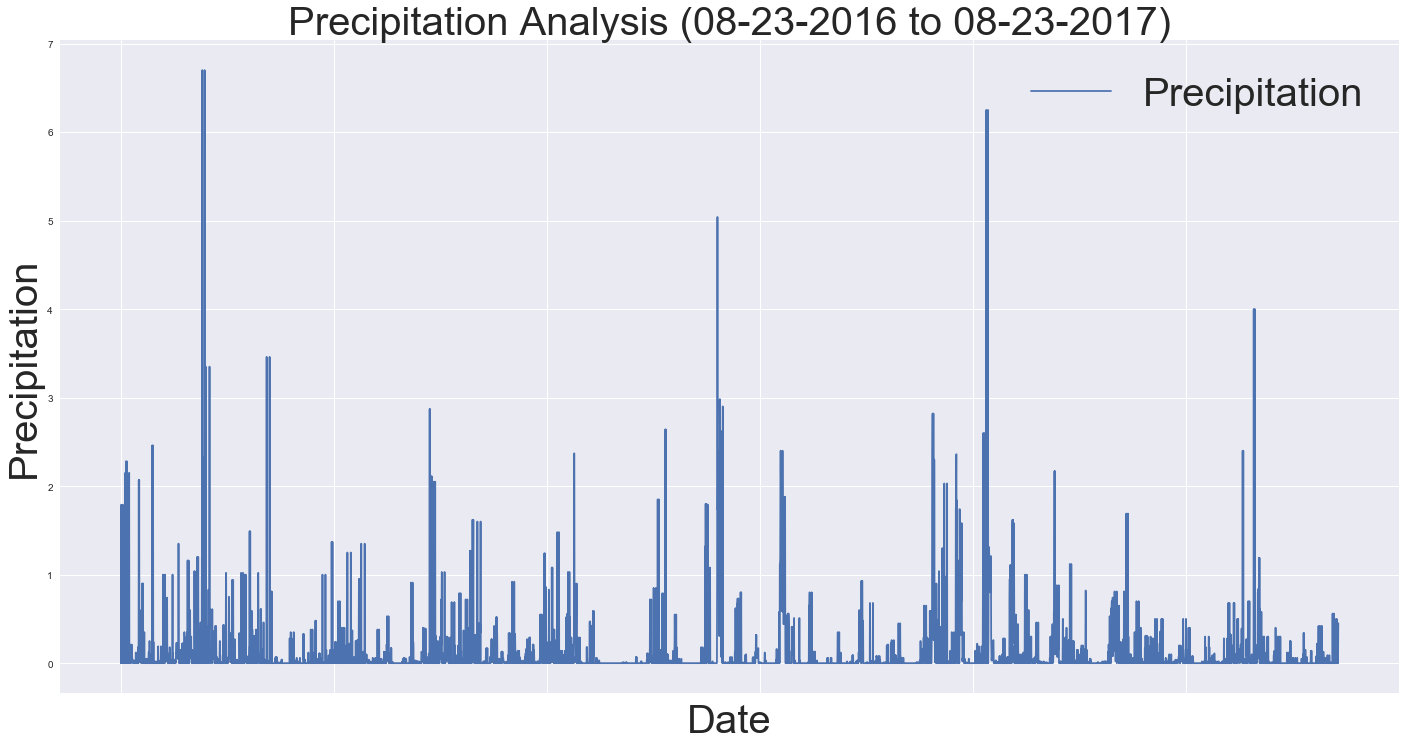

In [228]:
prcp_plot = prcp_df.plot(figsize = (24, 12), sort_columns=True, use_index=True, grid=True)
plt.ylabel('Precipitation', fontsize = 40)
plt.xlabel('Date', fontsize = 40)
plt.legend(["Precipitation"], fontsize = 40)
plt.title("Precipitation Analysis (08-23-2016 to 08-23-2017)", fontsize = 40)
plt.xticks(rotation=45)
plt.show()

In [229]:
# Summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,5714.000000
mean,0.125404
std,0.396126
min,0.000000
25%,0.000000
50%,0.000000
75%,0.060000
max,6.700000
